In [1]:
import pandas as pd
import json
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

# Load Data

In [3]:
# Returns one dataframe containing all json in data folder
# def load_all_user_json():
#     dataframes = []
#     pattern = r"UserTimeline_(\w+)\.json"
    
#     for filename in os.listdir("data"):
#         match = re.search(pattern, filename)
#         temp_df = pd.read_json(f"data/{filename}", convert_dates = ["created_at"])
#         temp_df["username"] = match.group(1)
#         dataframes.append(temp_df)
    
#     results = pd.concat(dataframes)
#     results = results[['username'] + list(results.columns[:-1])]
#     return results

    
# df = load_all_user_json()
# df

# Use this if running from jupyter notebook
def load_all_user_json():
    dataframes = []
    pattern = r"UserTimeline_(\w+)\.json"
    
    for filename in os.listdir():
        if (filename == '.config' or filename == 'sample_data'):
          continue
        match = re.search(pattern, filename)
        print(match)
        temp_df = pd.read_json(f"{filename}", convert_dates = ["created_at"])
        temp_df["username"] = match.group(1)
        dataframes.append(temp_df)
    
    results = pd.concat(dataframes)
    results = results[['username'] + list(results.columns[:-1])]
    return results

df = load_all_user_json()
df

<re.Match object; span=(0, 28), match='UserTimeline_Reductress.json'>
<re.Match object; span=(0, 31), match='UserTimeline_TheBabylonBee.json'>
<re.Match object; span=(0, 30), match='UserTimeline_HardDriveMag.json'>
<re.Match object; span=(0, 26), match='UserTimeline_TheOnion.json'>


,username,created_at,id,id_str,text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,Reductress,2023-06-02 21:00:49+00:00,1664738866065031176,1664738866065031168,"Hairstylist Fails to Replicate Face, Body, Lif...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664738864534024193, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,42,764,False,False,0.0,en,NaN,NaN,NaN,NaN
1,Reductress,2023-06-02 20:01:26+00:00,1664723920442851328,1664723920442851328,Cool! This Woman Either Has No Unread Emails o...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664723918328832002, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,20,188,False,False,0.0,en,NaN,NaN,NaN,NaN
2,Reductress,2023-06-02 19:01:09+00:00,1664708749158764569,1664708749158764544,Mermaidcore! This Woman Hasn't Gotten Up or Wa...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664708747954999307, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,55,464,False,False,0.0,en,NaN,NaN,NaN,NaN
3,Reductress,2023-06-02 18:11:34+00:00,1664696272639459330,1664696272639459328,"Get the ""HOMOSEXUAL"" beer coozies and more in ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664696266176057350, 'id_str...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,4,108,False,False,0.0,en,NaN,NaN,NaN,NaN
4,Reductress,2023-06-02 18:02:06+00:00,1664693889767288838,1664693889767288832,How to Have Dinner With Your Parents Without D...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664693888366379008, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,43,723,False,False,0.0,en,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,TheOnion,2023-01-29 20:35:05+00:00,1619796295891226624,1619796295891226624,Nick Bosa: The defensive end fully utilizes hi...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,2,66,False,False,0.0,en,NaN,NaN,NaN,NaN
3246,TheOnion,2023-01-29 20:30:06+00:00,1619795038451515393,1619795038451515392,Nick Bosa Quietly Admits To Offensive Tackle T...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1619795017714786307, 'id_str...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,46,630,False,False,0.0,en,NaN,NaN,NaN,NaN
3247,TheOnion,2023-01-29 20:15:06+00:00,1619791266887131139,1619791266887131136,A.J. Brown: The Eagles receiver has it all: ha...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,36,317,False,False,0.0,en,NaN,NaN,NaN,NaN
3248,TheOnion,2023-01-29 20:00:10+00:00,1619787507414990849,1619787507414990848,Deebo Samuel: The electric wideout led the lea..

# Process Data

In [4]:
# Pulls "day of the week" and "hour of the day" from `created_at`
def process_dates(df):
    temp_df = df.copy()
    
    temp_df["day_of_week"] = df["created_at"].dt.day_name()
    temp_df["hour_of_day"] = df["created_at"].dt.hour
    
    return temp_df


df = process_dates(df)
df

,username,created_at,id,id_str,text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,day_of_week,hour_of_day
0,Reductress,2023-06-02 21:00:49+00:00,1664738866065031176,1664738866065031168,"Hairstylist Fails to Replicate Face, Body, Lif...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664738864534024193, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,42,764,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,21
1,Reductress,2023-06-02 20:01:26+00:00,1664723920442851328,1664723920442851328,Cool! This Woman Either Has No Unread Emails o...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664723918328832002, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,20,188,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,20
2,Reductress,2023-06-02 19:01:09+00:00,1664708749158764569,1664708749158764544,Mermaidcore! This Woman Hasn't Gotten Up or Wa...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664708747954999307, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,55,464,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,19
3,Reductress,2023-06-02 18:11:34+00:00,1664696272639459330,1664696272639459328,"Get the ""HOMOSEXUAL"" beer coozies and more in ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664696266176057350, 'id_str...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,4,108,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,18
4,Reductress,2023-06-02 18:02:06+00:00,1664693889767288838,1664693889767288832,How to Have Dinner With Your Parents Without D...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664693888366379008, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,43,723,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,TheOnion,2023-01-29 20:35:05+00:00,1619796295891226624,1619796295891226624,Nick Bosa: The defensive end fully utilizes hi...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,2,66,False,False,0.0,en,NaN,NaN,NaN,NaN,Sunday,20
3246,TheOnion,2023-01-29 20:30:06+00:00,1619795038451515393,1619795038451515392,Nick Bosa Quietly Admits To Offensive Tackle T...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1619795017714786307, 'id_str...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,46,630,False,False,0.0,en,NaN,NaN,NaN,NaN,Sunday,20
3247,TheOnion,2023-01-29 20:15:06+00:00,1619791266887131139,1619791266887131136,A.J. Brown: The Eagles receiver has it all: ha...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,36,317,False,False,0.0,en,NaN,NaN,NaN,NaN,Sunday,20
3248,TheOnion,20

In [5]:
# Average Engagement Rate: 
# Measures the number of engagements a content gets to the percentage of audience. 

# Average engagement rate = (likes + shares) / total followers
def process_avg_engagement_rate(df):
    temp_df = df.copy()
    
    temp_df["avg_engagement_rate"] = temp_df.apply(lambda row : (row["favorite_count"] + row["retweet_count"]) / row["user"]["followers_count"], axis = 1)
    return temp_df

df = process_avg_engagement_rate(df)

In [10]:
# Amplification Rate:
# Measures the ratio of shares per post to the number of overall followers. 

def process_amplification_rate(df): 
    temp_df = df.copy()

    temp_df["amplification_rate"] = temp_df.apply(lambda row : row["retweet_count"] / row["user"]["followers_count"], axis = 1)
    return temp_df

df = process_amplification_rate(df)


# Basic Functions

In [11]:
# Given a pandas series, return the link of the tweet
def get_tweet_link(series):
    username = series["user"]["screen_name"]
    return f"https://twitter.com/{username}/status/{series['id']}"

tweet_link = get_tweet_link(df.iloc[0])
tweet_link

'https://twitter.com/Reductress/status/1664738866065031176'

In [12]:
def find_retweets(df):
    return df[df["retweeted_status"].notnull()]

df_retweets = find_retweets(df)
df_retweets

,username,created_at,id,id_str,text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,day_of_week,hour_of_day,avg_engagement_rate,amplification_rate
8,Reductress,2023-06-02 14:35:20+00:00,1664641855055691777,1664641855055691776,"RT @Reductress: ""How to Stay Productive When T...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,13,0,False,False,NaN,en,{'created_at': 'Thu Jun 01 14:22:15 +0000 2023...,NaN,NaN,NaN,Friday,14,0.000043,0.000043
43,Reductress,2023-05-29 14:08:45+00:00,1663185614265524224,1663185614265524224,RT @AndrewsMcMeel: How to Stay Productive When...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,6,0,False,False,NaN,en,{'created_at': 'Mon May 29 14:01:08 +0000 2023...,NaN,NaN,NaN,Monday,14,0.000020,0.000020
95,Reductress,2023-05-23 15:01:15+00:00,1661024498722934791,1661024498722934784,"RT @Reductress: The ""Extremely Gay and Brave"" ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1659622221399183362, 'id_str...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,16,0,False,False,0.0,en,{'created_at': 'Fri May 19 18:09:18 +0000 2023...,NaN,NaN,NaN,Tuesday,15,0.000052,0.000052
139,Reductress,2023-05-18 13:55:31+00:00,1659196015780708353,1659196015780708352,RT @AndrewsMcMeel: From “’Doing What You Love’...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,7,0,False,False,NaN,en,{'created_at': 'Thu May 18 13:00:11 +0000 2023...,NaN,NaN,NaN,Thursday,13,0.000023,0.000023
167,Reductress,2023-05-15 14:15:45+00:00,1658113944345620480,1658113944345620480,RT @UnionHallNY: TONIGHT: @Reductress Presents...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,4,0,False,False,NaN,en,{'created_at': 'Mon May 15 13:00:02 +0000 2023...,NaN,NaN,NaN,Monday,14,0.000013,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,TheOnion,2023-04-21 15:23:33+00:00,1649433698528370690,1649433698528370688,RT @KartoonistKelly: I call out the anniversar...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,39,0,False,False,0.0,en,{'created_at': 'Thu Apr 20 17:53:31 +0000 2023...,NaN,NaN,NaN,Friday,15,0.000003,0.000003
1336,TheOnion,2023-04-13 16:07:54+00:00,1646545758059896832,1646545758059896832,RT @KartoonistKelly: Class.\nMy latest:\nhttps...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,169,0,False,False,0.0,en,{'created_at': 'Mon Apr 10 17:44:58 +0000 2023...,NaN,NaN,NaN,Thursday,16,0.000014,0.000014
1355,TheOnion,2023-04-12 21:06:16+00:00,1646258454133104644,1646258454133104640,RT @KartoonistKelly: During his time of TRIAL ...,False,"{'hashtags': [], 'symbols

In [13]:
def find_not_retweets(df):
    return df[df["retweeted_status"].isna()]

df_not_retweets = find_not_retweets(df)
df_not_retweets

,username,created_at,id,id_str,text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,day_of_week,hour_of_day,avg_engagement_rate,amplification_rate
0,Reductress,2023-06-02 21:00:49+00:00,1664738866065031176,1664738866065031168,"Hairstylist Fails to Replicate Face, Body, Lif...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664738864534024193, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,42,764,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,21,0.002644,1.377754e-04
1,Reductress,2023-06-02 20:01:26+00:00,1664723920442851328,1664723920442851328,Cool! This Woman Either Has No Unread Emails o...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664723918328832002, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,20,188,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,20,0.000682,6.560733e-05
2,Reductress,2023-06-02 19:01:09+00:00,1664708749158764569,1664708749158764544,Mermaidcore! This Woman Hasn't Gotten Up or Wa...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664708747954999307, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,55,464,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,19,0.001703,1.804201e-04
3,Reductress,2023-06-02 18:11:34+00:00,1664696272639459330,1664696272639459328,"Get the ""HOMOSEXUAL"" beer coozies and more in ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664696266176057350, 'id_str...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,4,108,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,18,0.000367,1.312147e-05
4,Reductress,2023-06-02 18:02:06+00:00,1664693889767288838,1664693889767288832,How to Have Dinner With Your Parents Without D...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664693888366379008, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,43,723,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,18,0.002513,1.410558e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,TheOnion,2023-01-29 20:35:05+00:00,1619796295891226624,1619796295891226624,Nick Bosa: The defensive end fully utilizes hi...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,2,66,False,False,0.0,en,NaN,NaN,NaN,NaN,Sunday,20,0.000006,1.698947e-07
3246,TheOnion,2023-01-29 20:30:06+00:00,1619795038451515393,1619795038451515392,Nick Bosa Quietly Admits To Offensive Tackle T...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1619795017714786307, 'id_str...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,46,630,False,False,0.0,en,NaN,NaN,NaN,NaN,Sunday,20,0.000057,3.907577e-06
3247,TheOnion,2023-01-29 20:15:06+00:00,1619791266887131139,1619791266887131136,A.J. Brown: The Eagles receiver has it all: ha...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https:

# Basic Metrics

### Top Tweets

In [14]:
# Top 5 tweets with most likes (favorited)
def most_liked_tweets(df, count):
    return df.sort_values(by = ["favorite_count"], ascending = False).head(count)


def most_liked_tweets_by_users(df, count = 5):
    usernames = pd.unique(df["username"])
    results = {}
    for username in usernames:
        results[username] = most_liked_tweets(df[df["username"] == username], count)
    return results
    

dfs_top5 = most_liked_tweets_by_users(df, 5)
dfs_top5["Reductress"]

,username,created_at,id,id_str,text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,day_of_week,hour_of_day,avg_engagement_rate,amplification_rate
2382,Reductress,2022-09-08 17:31:01+00:00,1567928508218736640,1567928508218736640,Cute! Queen Elizabeth's Corgis Prepare to Be B...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1567928506117398528, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,24404,212457,False,False,0.0,en,NaN,NaN,NaN,NaN,Thursday,17,0.776991,0.080054
2673,Reductress,2022-08-05 22:00:43+00:00,1555675190394232834,1555675190394232832,Wow! This Middle Aged Man Fell In Love With Hi...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,5025,51690,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,22,0.186046,0.016484
2538,Reductress,2022-08-21 16:00:25+00:00,1561382724442652673,1561382724442652672,Nice! New Collar Delivers a Shock Every Time Y...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1561382722693627907, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,3327,28908,False,False,0.0,en,NaN,NaN,NaN,NaN,Sunday,16,0.105743,0.010914
1930,Reductress,2022-10-29 21:00:17+00:00,1586462954102624256,1586462954102624256,How to Pass Off Your IBS Bathroom Trips as a C...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1586462952747573250, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,1663,19245,False,False,0.0,en,NaN,NaN,NaN,NaN,Saturday,21,0.068586,0.005455
1010,Reductress,2023-02-11 22:00:23+00:00,1624528804377989120,1624528804377989120,Quadruple Threat! Barbra Streisand Has a Knife...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1624528803153252354, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,1504,14852,False,False,0.0,en,NaN,NaN,NaN,NaN,Saturday,22,0.053654,0.004934


In [15]:
get_tweet_link(dfs_top5["HardDriveMag"].iloc[0])

'https://twitter.com/HardDriveMag/status/1531401966567493634'

In [16]:
def find_average_by_users(dataframes, column_name, avg_type = "mean"):
    usernames = pd.unique(df["username"])
    results = {}
    for username in usernames:
        if avg_type == "mean":
            results[username] = df[df["username"] == username][column_name].mean()
        elif avg_type == "median":
            results[username] = df[df["username"] == username][column_name].median()
    return results


print("Mean favorites   : ")
for username, mean in find_average_by_users(df_not_retweets, "favorite_count", "mean").items():
    print(f"{username:16} : {mean:.2f}")

print("-----\n")

print("Median favorites : ")
for username, median in find_average_by_users(df_not_retweets, "favorite_count", "median").items():
    print(f"{username:16} : {median}")

Mean favorites   : 
Reductress       : 707.47
TheBabylonBee    : 6833.81
HardDriveMag     : 2877.49
TheOnion         : 1848.31
-----

Median favorites : 
Reductress       : 385.0
TheBabylonBee    : 3295.0
HardDriveMag     : 1545.0
TheOnion         : 805.0


In [20]:
print("Mean engagement rate   : ")
for username, mean in find_average_by_users(df_not_retweets, "avg_engagement_rate", "mean").items():
    print(f"{username:16} : {mean:.5f}")
    
print("-----\n")

print("Median engagement rate   : ")
for username, median in find_average_by_users(df_not_retweets, "avg_engagement_rate", "median").items():
    print(f"{username:16} : {median:.5f}")

Mean engagement rate   : 
Reductress       : 0.00255
TheBabylonBee    : 0.00294
HardDriveMag     : 0.00998
TheOnion         : 0.00017
-----

Median engagement rate   : 
Reductress       : 0.00139
TheBabylonBee    : 0.00142
HardDriveMag     : 0.00525
TheOnion         : 0.00007


In [22]:
print("Mean amplification rate   : ")
for username, mean in find_average_by_users(df_not_retweets, "amplification_rate", "mean").items():
    print(f"{username:16} : {mean:.6f}")
    
print("-----\n")

print("Median amplification rate   : ")
for username, median in find_average_by_users(df_not_retweets, "amplification_rate", "median").items():
    print(f"{username:16} : {median:.6f}")

Mean amplification rate   : 
Reductress       : 0.000234
TheBabylonBee    : 0.000394
HardDriveMag     : 0.001048
TheOnion         : 0.000015
-----

Median amplification rate   : 
Reductress       : 0.000121
TheBabylonBee    : 0.000163
HardDriveMag     : 0.000416
TheOnion         : 0.000005


# Plots

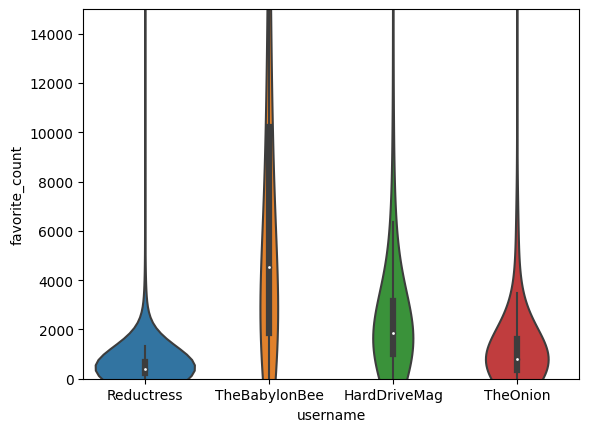

In [19]:
# Plot favorite count of each user using a violin plot
def plot_favorite_count_by_user(df):
    fig, ax = plt.subplots()
    sns.violinplot(data = df, x = "username", y = "favorite_count", gridsize = 1000)
    ax.set_ylim(0, 15000)
    plt.show()
    
    
plot_favorite_count_by_user(df_not_retweets)

In [20]:
# Plot 4 subplots of counts of tweets by hour of the day
def plot_tweet_counts(df, column_name, order):
    grid = sns.FacetGrid(data = df, col = "username", col_wrap = 2, aspect = 1.5, height = 4, sharex = False, sharey = False)
    
    grid.map(sns.countplot, column_name, order = order)
    grid.set_axis_labels(column_name, "Count")
    grid.set_titles('{col_name}')
    plt.subplots_adjust(hspace=0.4)
    
    plt.show()

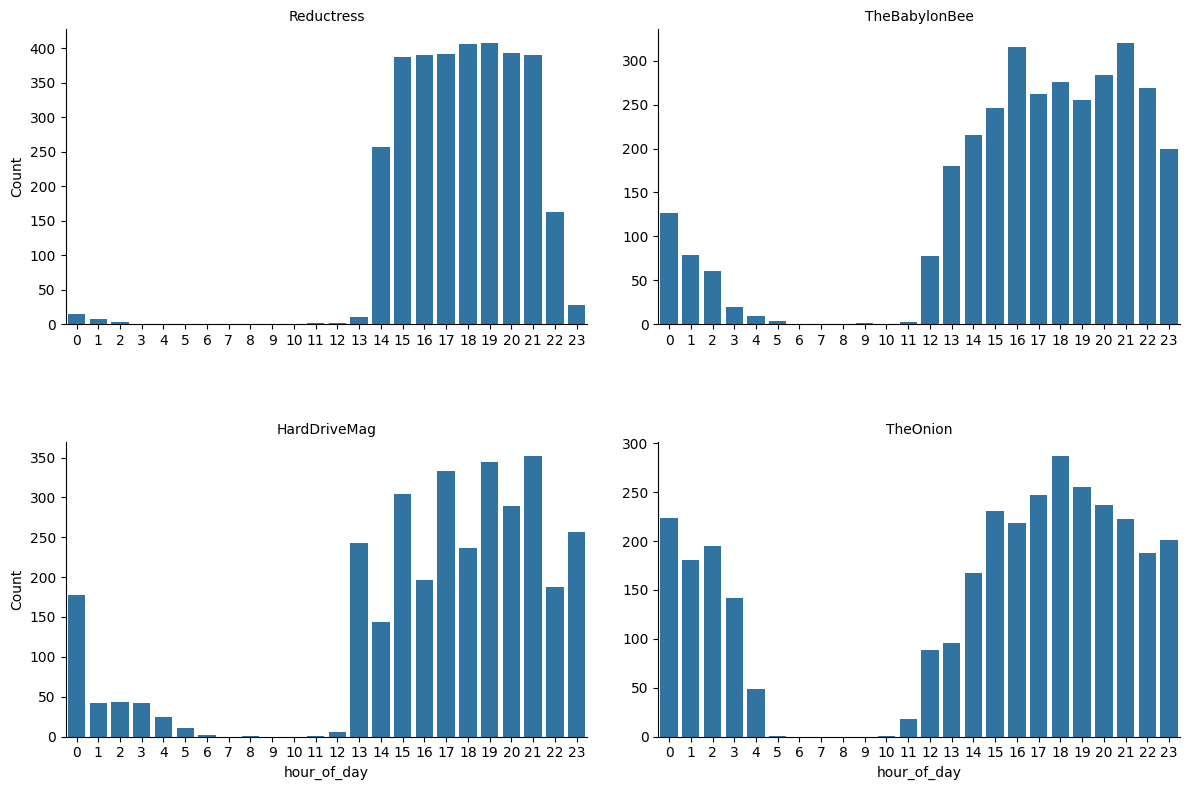

In [21]:
plot_tweet_counts(df, "hour_of_day", [i for i in range(24)])

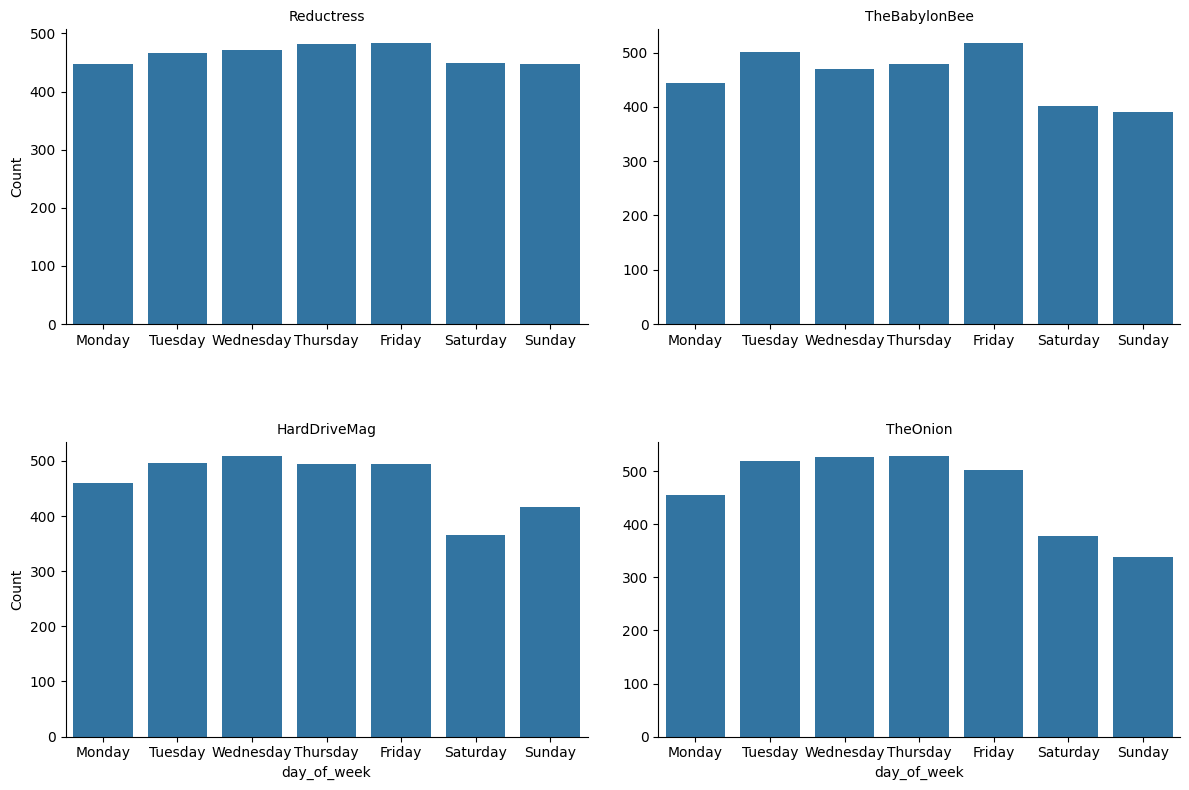

In [22]:
plot_tweet_counts(df, "day_of_week", ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])